> Generative Adversarial Networks(GAN):

GANs are a framework for teaching a DL model to capture the training data's distribution to generate new data from that same distribution.

They are made of two distinct models, a "generator" and a "discriminator".
- Generator: spawn 'fake' images that look like the training images.
- Discriminator: look at an image and output whether or not it is real or fake from the generator.

During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while discriminator is working to become a better detective and correcty classify the real and fake images.

The equilibrium of this game is when generator is generating perfect fakes that loko as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.

> notation

* discriminator's *

x: data representing an image
D(x): discriminator network which outputs the probability that x came from training data rather than the generator

since we are dealing with images, the input to D(x) is an image of CHW size 3*64*64.

D(x) should be high when x comes from training data and low when x comes from the generator. 

D(x) can also be thought of as a traditional binary classifier.

* generator's *

z: latent space vector sampled from a standard normal distribution
G(z): generator function which maps the latent vector z to data-space

The goal of G: estimate the dist. that the training data comes from (p_data) so it can generate fake samples from that estimated dist.(p_g)

So D(G(z)) is the prob. that the output of the G is a real image.

D and G play a minimax game 
- D tries to maximize the prob that it correctly classifies reals and fakes(logD(x))
- G tries to minimize the prob that D will predict its outputs are fake(log(1-D(G(x))))

In theory, the solution to this minimax game is where p_g=p_data, and the discriminator guesses randomly if the inputs are real or fake. 

However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point.

> DCGAN:

a direct extension of the GAN, except that it explicitly uses convolutional and convolutional-transpose layers in the D and G, respectively.

D is made up of strided conv. layers, batch norm layers, and LeakyReLU activations. The input is a 3*64*64 image and output is a scalar prob that the input is from the real data dist.

G is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, z, that is drawn from a standard normal dist. and the output is 3*64*64 RGB image.

The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. 

In the paper, the authors also give some tips about
- how to setup the optimizers,
- how to calculate the loss functions, 
- how to initialize the model weights.

In [4]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) 
# use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


> Inputs:
- dataroot: the path to the root of the dataset folder.
- workers: # of worker threads for loading the data with the DataLoader
- batch_size: batch size used in training. DCGAN paper uses a bs of 128
- image_size: spatial size of the images used for training. The implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed.
- nc: number of color channels in the input images. For color image, 3
- nz: length of latent vector
- ngf: depth of feature maps carried through the generator
- ndf: depth of feature maps propagated through the discriminator
- num_epochs: number of training epochs to run. Training for longer will probably lead to better results but will also take much longer.
- lr: learning rate for training. should be 0.0002(paper)
- beta1: beta1 hyperparameter for Adam optimizers (0.5)
- ngpu: # of GPUs available. 0 -> CPU.

In [5]:
# Root directory for dataset
dataroot = "../input/celeba-dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

> Data

The dataset will download as a file named img_align_celeba.zip. Once downloaded, create a directory named celeba and extract the zip file into that directory. Then, set the dataroot input for this notebook to the celeba directory you just created.

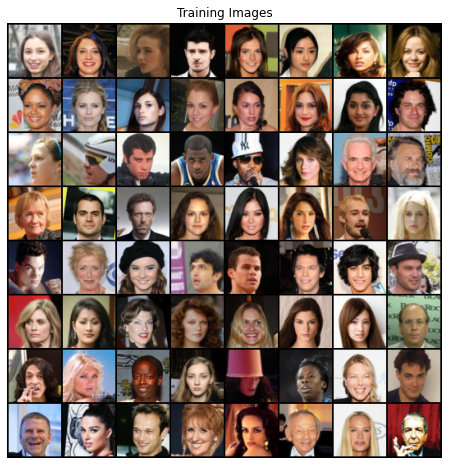

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


> implementation

- weight initialization strategy
- generator
- discriminator
- loss functions
- training loop

> Weight Initialization

From the DCGAN paper, the autors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

The weights_init function takes an initialized model as input and reinitializes all conv, conv-transpose, and batch normalization layers to meet this criteria.

This function is applied to the models immediately after initialization.

In [9]:
# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

> Generator

is designed to map the latent space vector(z) to data-space.

Since our data are images, converting z to data-space means creating a RGB image with the same size as the training images.

In practice, it is accomplished through a series of strided two dimensional conv. transpose layers, each paired with a 2d batch norm layer and a relu activation.

The output of G is fed through a tanh function to return it to the input data range of [-1, 1].
* batch norm functions after the conv-transpose layers. These layers help with the flow of gradients during training.

See how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code.

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf *8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. (nc) x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)

instantiate the generator and apply the weights_init function.

see how the generator object is structured.

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


> Discriminator

D is a binary classification network that takes an image as input and outputs a scalar prob. that the image is real or fake.

D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d and LeakyReLU layers, and outputs the final prob through a Sigmoid activation function.

This architecture can be extended with more layers if necessary for the problem,but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs.

The paper mentions it is a good practice to use strided convolution rather than pooling to downsample. because it lets the network learn its own pooling function.

Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of G and D.

In [13]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32nn.
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

apply the weights_init function, and print the model’s structure.

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


> Loss Functions and Optimizers

With D and G setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss (BCELoss) function.

we define our real label as 1 and the fake label as 0.

we set up two separate optimizers, one for D and one for G. Both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5.

For keeping track of the generator’s learning progression, generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (ex. fixed_noise).
In the training loop, we will periodically input this fixed_noise into G, and over the iterations we will see images form out of the noise.

In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

> Training

Part 1: Train the Discriminator
- the goal of training the discriminator is to max the prob of correctly classifying a given input as real or fake. 
- we wish to "update the discriminator by ascending its stochastic gradient".

- first, construct a batch of real samples from the training set, forward pass through D, calculate the loss (log(D(x)), then calculate the gradients in a backward pass.

- secondly, construct a batch of fake samples with the current generator, forward pass this batch through D, calculate loss (log(1 - D(G(z))), and accumulate the gradients with a backward pass.

- with the gradients accumulated from both all-real and all-fake batches, we call a step of Discriminator's optimizer.

Part 2: Train the Generator
- to min log(1-D(G(z))) to generate better fakes
- early in the learning process, doesn't work well.
- instead wish to max log(D(G(z)). classifying the Generator output from Part1 with Discriminator, computing G's loss using real labels as GT, computing G's gradients in a backward pass, and finally updating G's parameters with an optimzer step.

Finally statistic report & push our fixed_noise batch through generator to visually track the progress of G's training.

training statistics reported:
- Loss_D
- Loss_G
- D(x): average output (across the batch) of d for the all real batch. start close to 1 -> converge to 0.5 when G gets better.
- D(G(z)): average D outputs for the all fake batch. 0 -> 0.5

In [ ]:
# Trainig Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.7891	Loss_G: 6.4769	D(x): 0.6739	D(G(z)): 0.6682 / 0.0028
[0/5][50/1583]	Loss_D: 0.0423	Loss_G: 10.7845	D(x): 0.9756	D(G(z)): 0.0005 / 0.0001
[0/5][100/1583]	Loss_D: 0.0367	Loss_G: 12.6256	D(x): 0.9833	D(G(z)): 0.0048 / 0.0000
[0/5][150/1583]	Loss_D: 0.2340	Loss_G: 5.9906	D(x): 0.9010	D(G(z)): 0.0908 / 0.0043
[0/5][200/1583]	Loss_D: 0.6311	Loss_G: 8.2067	D(x): 0.9718	D(G(z)): 0.3704 / 0.0006
[0/5][250/1583]	Loss_D: 0.6223	Loss_G: 3.2010	D(x): 0.7743	D(G(z)): 0.2000 / 0.0885
[0/5][300/1583]	Loss_D: 0.3406	Loss_G: 2.8271	D(x): 0.8965	D(G(z)): 0.1686 / 0.1018
[0/5][350/1583]	Loss_D: 1.1807	Loss_G: 8.2599	D(x): 0.9445	D(G(z)): 0.5975 / 0.0028
[0/5][400/1583]	Loss_D: 0.3476	Loss_G: 3.8719	D(x): 0.8114	D(G(z)): 0.0766 / 0.0352
[0/5][450/1583]	Loss_D: 0.5427	Loss_G: 5.1151	D(x): 0.8310	D(G(z)): 0.2359 / 0.0111
[0/5][500/1583]	Loss_D: 0.8101	Loss_G: 7.3267	D(x): 0.9325	D(G(z)): 0.4499 / 0.0024
[0/5][550/1583]	Loss_D: 0.3080	Loss_G: 4.1078	D(x):

> Results

Finally, check out how we did.

Three results:
1. see how D and G's losses changed during training.
2. visualize G's output on the fixed_noise batch for every epoch.
3. look at a batch of real data next to a batch of fake data from G 

Loss versus training iteration

In [ ]:
# Plot of D & G's losses versus training iterations
plt.figure(figsize(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("losses")
plt.legend()
plt.show()

Visualization of G's progression

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Real Image vs Fake Image

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis=("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5,
                                        normalize=True).cpu(), (1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()